#  <span style="font-family: Latin Modern Roman; font-size: 35px; font-weight: bold;"> Project 2. Unsupervised Learning with Recommender Systems </span>

## <span style="font-family: Latin Modern Roman; font-size: 25px;"> 1. Introduction </span>
<div style="text-align: justify;">

Recommender systems are capable of providing consumers with tailored suggestions, pointing them toward products they are likely to appreciate but would not have discovered on their own, by examining trends in their behavior, interests, and interactions. These systems are essential for raising engagement in the world of music streaming and discovery services such as Last.fm. In order to match listeners with music that suits their likes, the aim of this project is to **construct a recommender system** that combs through the enormous database of songs, artists, and genres based on information of listener history utilizing detailed user interactions and artist information to predict and influence future listens.

For an understanding of users' listening likes and behaviors in the context of music streaming services such as Last.fm, listening counts are an essential measure. In contrast to explicit ratings, which represent user preferences directly, listening counts are an example of **implicit feedback**. By recording the frequency of engagement with various artists, they offer insights into user behavior, but they do not indicate the level of preference. A high listening count implies a user's affinity for an artist, while the absence of listening activity doesn't necessarily indicate dislike—it could simply mean the user has yet to discover the artist.

The combination of listening counts, artist popularity, user-generated tags, and the rich set of artist attributes in this dataset provides a comprehensive foundation for creating a music recommender system making use of complex models capable of interpreting these implicit signals:

- **Bayesian Personalized Ranking (BPR)**:

- **Weighted Matrix Factorization (WFM)**:

- **Factorization Machines (FM)**:

</div>

---

## <span style="font-family: Latin Modern Roman; font-size: 25px;"> 2. Exploratory Data Analysis </span>

## <span style="font-family: Latin Modern Roman; font-size: 20px; font-style: italic;"> Data Tables </span>
<div style="text-align: justify;">

**Artists Data:**

This table contains information about music artists listened to and tagged by the users.

* `artistID`: unique identifier for each artist.

* `name`: name of the artist.

* `freq`: how often the artist appears in the dataset.

* `listeners`: number of users who have listened to the artist.

**Tags Data:**

This table contains the set of tags or genres available.

* `tagID`: unique identifier for each tag.

* `tagValue`: name of the tag, which can represent a genre, mood, era, or any other music-related attribute.

**User-Artist Data Data:**

This table captures which artists users have listened to, including a count of listening events.

* `userID`: unique identifier for each user.

* `artistID`: artist listened to by the user.

* `weight`: count of how many times the user has listened to the artist, indicative of the user's preference strength for that artist.

**User-Tagged Artists Data**

This table contains the tags that users have assigned to artists, along with timestamps indicating when the tagging occurred.

* `userID`, `artistID`, `tagID`: identifiers linking users, artists, and tags.

* `day`, `month`, `year`: date when the tag was assigned, providing temporal context.


In [27]:
import pandas as pd 

artists = pd.read_csv('./hetrec2011-lastfm-2k/artists-v2.dat', header=0, sep='\t')
user_tag_artist = pd.read_csv('./hetrec2011-lastfm-2k/user_taggedartists.dat', header=0, sep='\t')
tags = pd.read_csv('hetrec2011-lastfm-2k/tags.dat', header=0, sep='\t', encoding='latin-1')
users = pd.read_csv('hetrec2011-lastfm-2k/user_artists.dat',header=0, sep='\t')


In [28]:
print("Artists Data:")
print(artists.head())

Artists Data:
   artistID            name  freq  listeners
0        89       Lady Gaga   611    3798959
1       289  Britney Spears   522    3243214
2       288         Rihanna   484    4542147
3       227     The Beatles   480    3658694
4       300      Katy Perry   473    3721531


In [29]:
print("\nUser-Tagged Artists Data:")
print(user_tag_artist.head())


User-Tagged Artists Data:
   userID  artistID  tagID  day  month  year
0       2        52     13    1      4  2009
1       2        52     15    1      4  2009
2       2        52     18    1      4  2009
3       2        52     21    1      4  2009
4       2        52     41    1      4  2009


In [30]:
print("\nTags Data:")
print(tags.head())


Tags Data:
   tagID           tagValue
0      1              metal
1      2  alternative metal
2      3          goth rock
3      4        black metal
4      5        death metal


In [31]:
print("\nUsers Data:")
print(users.head())


Users Data:
   userID  artistID  weight
0       2        51   13883
1       2        52   11690
2       2        53   11351
3       2        54   10300
4       2        55    8983


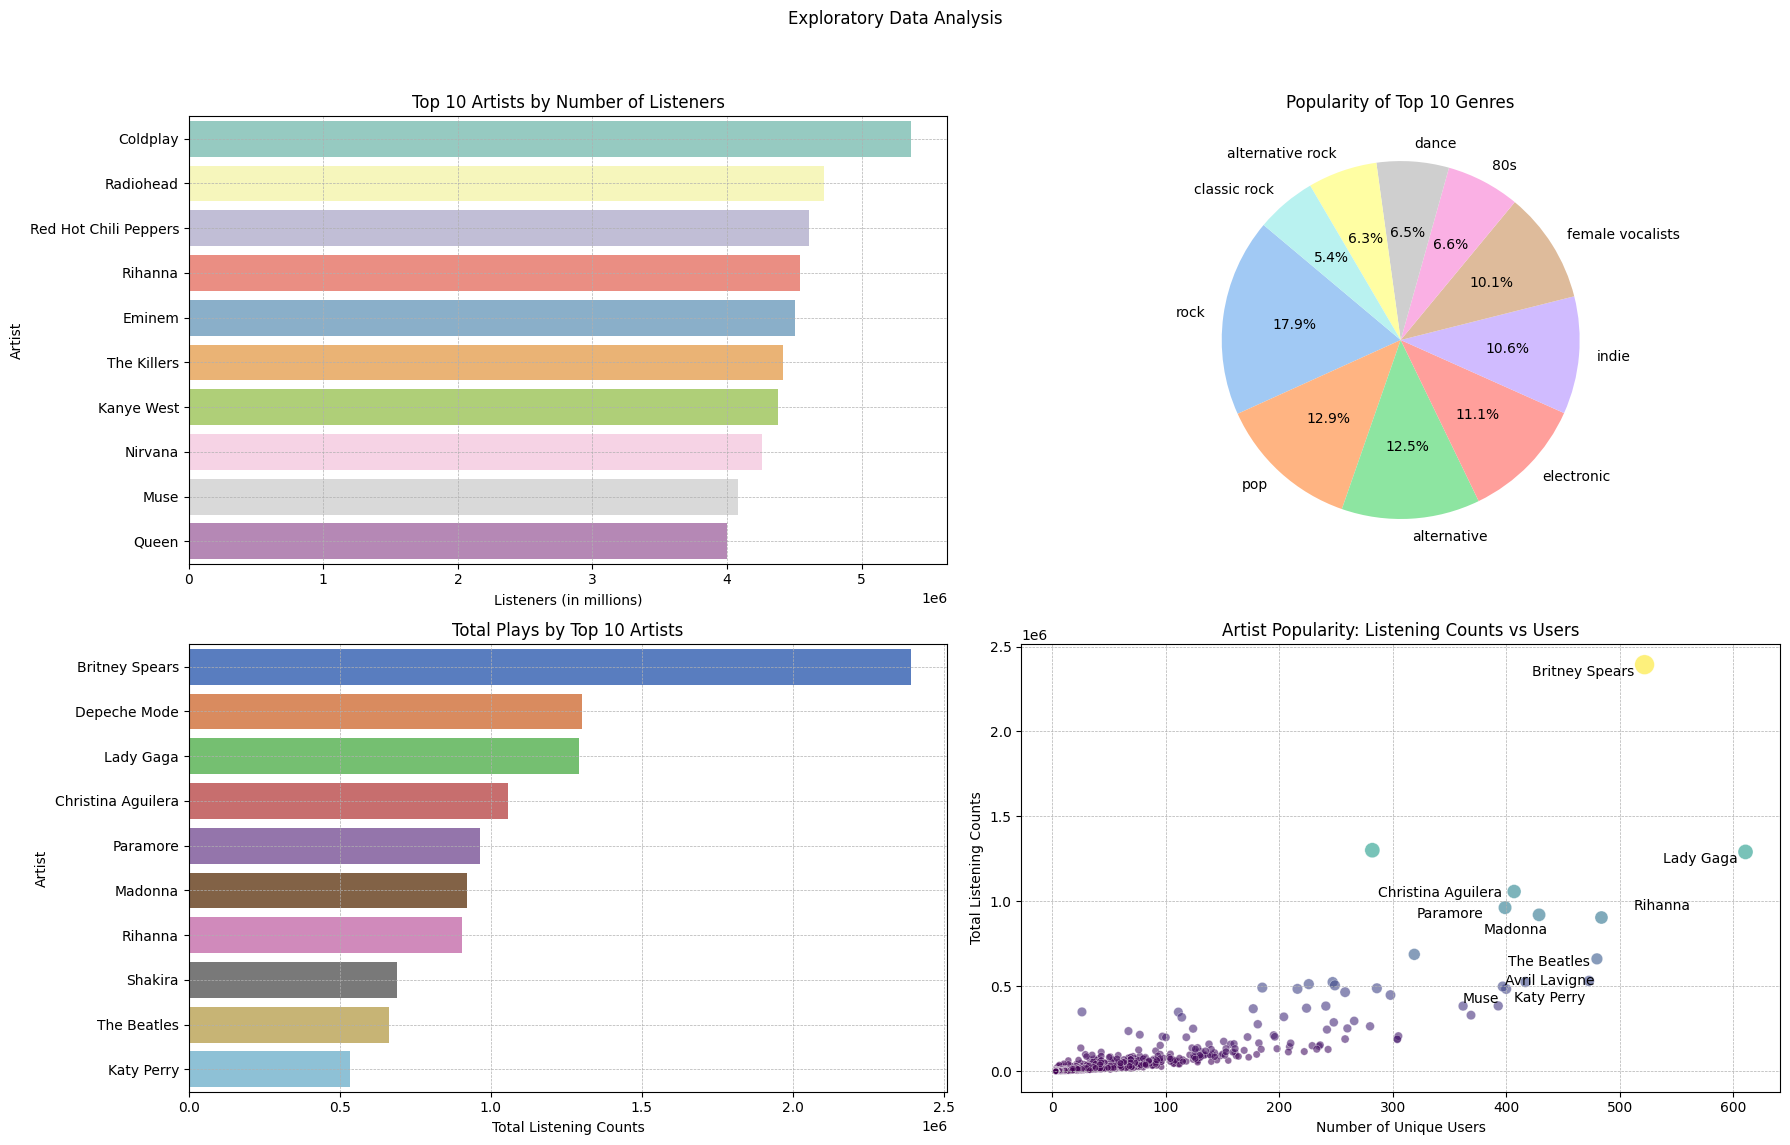

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
import warnings

warnings.filterwarnings("ignore")

# Subplot area
fig, axes = plt.subplots(2, 2, figsize = (18, 12))
fig.suptitle('Exploratory Data Analysis')

# Popularity of Artists
top_artists = artists.sort_values(by = 'listeners', ascending = False).head(10)
sns.barplot(x = 'listeners', y = 'name', data = top_artists,  ax = axes[0, 0], palette = 'Set3')
axes[0, 0].set_title('Top 10 Artists by Number of Listeners')
axes[0, 0].set_xlabel('Listeners (in millions)')
axes[0, 0].set_ylabel('Artist')
axes[0, 0].grid(True, which = "both", ls = "--", linewidth = 0.5)

# Popularity of Genres
genre_counts = user_tag_artist.groupby('tagID').size().sort_values(ascending=False).head(10)
top_genres = pd.merge(genre_counts.reset_index(), tags, how = 'left', on = 'tagID')
axes[0, 1].pie(top_genres[0], labels = top_genres['tagValue'], autopct = '%1.1f%%', startangle = 140, colors = sns.color_palette('pastel'))
axes[0, 1].set_title('Popularity of Top 10 Genres')

# Total Plays by Artist (Listening Counts)
total_plays_by_artist = users.groupby('artistID')['weight'].sum().sort_values(ascending=False).head(10)
top_artists_by_plays = pd.merge(total_plays_by_artist.reset_index(), artists, on = 'artistID')
sns.barplot(x = 'weight', y = 'name', data=top_artists_by_plays,  ax = axes[1, 0], palette = 'muted')
axes[1, 0].set_title('Total Plays by Top 10 Artists')
axes[1, 0].set_xlabel('Total Listening Counts')
axes[1, 0].set_ylabel('Artist')
axes[1, 0].grid(True, which = "both", ls = "--", linewidth = 0.5)

# Identifying the top 10 artists by popularity (considering both unique users and total listening counts)
artist_popularity = users.groupby('artistID').agg({'userID': pd.Series.nunique, 'weight': 'sum'})
artist_popularity = artist_popularity.merge(artists[['artistID', 'name']], on='artistID')
top_artists_by_popularity = artist_popularity.sort_values(by = ['userID', 'weight'], ascending = False).head(10)
sns.scatterplot(x = 'userID', y = 'weight', data = artist_popularity, size = 'weight', hue = 'weight', legend = False, alpha = 0.6, sizes = (20, 200),  ax = axes[1, 1], palette = 'viridis')
artist_names = []
for i, row in top_artists_by_popularity.iterrows():
    artist_names.append(plt.text(row['userID'], row['weight'], row['name']))
adjust_text(artist_names)
axes[1, 1].set_title('Artist Popularity: Listening Counts vs Users')
axes[1, 1].set_xlabel('Number of Unique Users')
axes[1, 1].set_ylabel('Total Listening Counts')
axes[1, 1].grid(True, which = "both", ls = "--", linewidth = 0.5)

plt.tight_layout(rect = [0, 0.03, 1, 0.95])
plt.show()


## <span style="font-family: Latin Modern Roman; font-size: 20px; font-style: italic;"> Insights Gained from Initial Exploration </span>
<div style="text-align: justify;">

By examining these visualizations, we gain a comprehensive picture of the popularity of different artists and genres within the dataset, as well as specific insights into the tastes and behavior of Last.fm users. Examining each graph in detail:

- **Top 10 Artists by Number of Listeners**
This graph highlights the artists with the largest unique listener bases. The key insight here is the broad appeal of these artists across different user segments. Artists topping this list, such as Coldplay, have successfully reached a wide audience, making them prime candidates for broad-based recommendations. Their high listener counts indicate a general popularity that transcends niche tastes, suggesting these artists are likely to be well-received by new listeners.

- **Popularity of Top 10 Genres**
The genre popularity pie chart reveals the most prevalent musical styles and attributes as defined by user tags. Genres dominating this chart, such as rock, pop, and electronic, reflect mainstream music tastes among Last.fm users. This insight is invaluable for understanding overarching trends in music preferences, allowing for genre-based recommendations that cater to the majority's taste. It also underscores the importance of tag-based classification in capturing user interests.

- **Total Plays by Top 10 Artists**
Ranking artists by total plays shows us who has not just wide appeal but deep engagement, as evidenced by high play counts. An artist like Britney Spears leading this chart suggests a dedicated fan base that listens to her music frequently. This distinction is crucial for recommendations, as artists with high total plays may resonate strongly with their listeners, encouraging repeat engagement. It indicates the potential for cultivating loyalty and sustained interest among users.

- **Artist Popularity: Listening Counts vs Unique Users**
This scatter plot combines the dimensions of unique listener counts and total plays to map out the landscape of artist popularity more comprehensively. It reveals a spectrum of artist profiles, from niche (lower unique users, lower total plays) to blockbuster (high unique users, high total plays). Crucially, it identifies artists who, despite having fewer listeners, engender high engagement (high plays but lower unique user counts) and those with wide but possibly shallower appeal (high unique users but lower plays per user). This nuanced view aids in tailoring recommendations to fit user preferences for depth (artists they might become deeply engaged with) versus breadth (new artists to explore).

Together, these visualizations paint a detailed picture of music consumption patterns on Last.fm, highlighting the importance of both broad appeal and deep engagement in understanding artist popularity. They provide a solid foundation for developing a recommender system that can cater to diverse user preferences, balancing mainstream and niche recommendations to enhance the music discovery experience.



</div>



---

## <span style="font-family: Latin Modern Roman; font-size: 25px;"> 3. Bayesian Personalized Ranking (BPR)</span>
<div style="text-align: justify;">
 
 Explain Bayesian Personalized Ranking
 
</div>

In [33]:
import tqdm as notebook_tqdm
import cornac
from cornac.utils import cache
from cornac.datasets import movielens
from cornac.eval_methods import RatioSplit
from cornac.models import UserKNN, ItemKNN
import pandas as pd
import numpy as np
from numpy import isnan
from numpy import linalg as LA

In [34]:
dataset_merged = pd.merge(artists, users, on='artistID')
dataset = cornac.data.Dataset.from_uir(users.itertuples(index=False))
VERBOSE = False

In [35]:
iknn_adj = ItemKNN(k=2, similarity="cosine", mean_centered=True, verbose=VERBOSE).fit(dataset) #dos neighbors y similitud coseno el item ya se encarga de hacer el ajustado el coseno
print(f"AdjustedCosine(1,3) = {iknn_adj.sim_mat[0, 2]:.3f}")

AdjustedCosine(1,3) = 0.951


In [36]:
print(f"R(3,1) = {iknn_adj.score(user_idx=2, item_idx=0):.1f}")
print(f"R(3,6) = {iknn_adj.score(user_idx=2, item_idx=5):.1f}")

R(3,1) = 369.5
R(3,6) = 226.0


In [103]:
# ItemKNN methods
SEED = 29
K = 50  # number of nearest neighbors

iknn_cosine = ItemKNN(
  k=K, similarity="cosine", name="ItemKNN-Cosine", verbose=VERBOSE
)
iknn_pearson = ItemKNN(
  k=K, similarity="pearson", name="ItemKNN-Pearson", verbose=VERBOSE
)
iknn_pearson_mc = ItemKNN(
  k=K, similarity="pearson", mean_centered=True, name="ItemKNN-Pearson-MC", verbose=VERBOSE
)
iknn_adjusted = ItemKNN(
  k=K, similarity="cosine", mean_centered=True, name="ItemKNN-AdjustedCosine", verbose=VERBOSE
)

In [104]:
from sklearn.model_selection import train_test_split
from cornac.models import ItemKNN
from cornac.metrics import RMSE


# Definimos nuestra experimentación con los modelos y métricas especificadas
experiment = cornac.Experiment(eval_method=cornac.eval_methods.RatioSplit(data=dataset_merged, test_size=0.1, random_state=42), 
                                models=[iknn_cosine, iknn_pearson, iknn_pearson_mc, iknn_adjusted],
                                metrics=[RMSE()])

# Ejecutamos la experimentación
experiment.run()


feedback = movielens.load_feedback(variant="100K")
ratio_split = RatioSplit(feedback, test_size=0.1, seed=SEED, verbose=VERBOSE)
cornac.Experiment(
  eval_method=ratio_split, 
  models=[iknn_cosine, iknn_pearson, iknn_pearson_mc, iknn_adjusted],
  metrics=[cornac.metrics.RMSE()],
).run()

ValueError: could not convert string to float: 't'

---

## <span style="font-family: Latin Modern Roman; font-size: 25px;"> 4. Weighted Matrix Factorization (WMF)</span>
<div style="text-align: justify;">
 
 Explain Weighted Matrix Factorization
 
</div>

---

## <span style="font-family: Latin Modern Roman; font-size: 25px;"> 5. Factorization Machines (FM)</span>
<div style="text-align: justify;">
 
 Explain Factorization Machines
 
</div>